In [1]:
import numpy as np
import math
from math import e
import pandas as pd
import qutip as qt
import random
from scipy.linalg import expm
import cmath

In [2]:
# function for checking whether or not matrix is hermitian
def check_hermitian(A):
    Adag = A.getH()
    if not (np.array_equal(np.matmul(Adag,A),np.matmul(A,Adag))):
        return False
    return True

In [3]:
def generate_hermitian(a,b,c,d):
    return np.matrix([[a,c+d*1j],[c-d*1j,b]])

In [4]:
def generate_random_hermitian(n):
    A = np.matrix(np.zeros((n,n),np.cdouble))
    constants = np.zeros(n*n)
    for i in range(0,n*n):
        constants[i] = random.random()
    constant_iter = 0
    for i in range(0,n-1):
        A[i,i] = constants[constant_iter]
        constant_iter += 1
        for j in range(i+1,n):
            A[i,j] = constants[constant_iter] + 1j*constants[constant_iter+1]
            A[j,i] = constants[constant_iter] - 1j*constants[constant_iter+1]
            constant_iter += 2
    A[n-1,n-1] = constants[constant_iter]
    return A

In [5]:
dim = 5
A=generate_random_hermitian(dim)

In [6]:
# should always be true
check_hermitian(A)

True

In [7]:
A

matrix([[0.61402496+0.j        , 0.10492625+0.29850062j,
         0.83048572+0.09231297j, 0.79294503+0.63333539j,
         0.66071891+0.75882516j],
        [0.10492625-0.29850062j, 0.81477382+0.j        ,
         0.06523609+0.42753872j, 0.33609989+0.08299428j,
         0.34236054+0.4862328j ],
        [0.83048572-0.09231297j, 0.06523609-0.42753872j,
         0.50793757+0.j        , 0.6279794 +0.79593255j,
         0.27738152+0.7163656j ],
        [0.79294503-0.63333539j, 0.33609989-0.08299428j,
         0.6279794 -0.79593255j, 0.20659352+0.j        ,
         0.84255839+0.39339966j],
        [0.66071891-0.75882516j, 0.34236054-0.4862328j ,
         0.27738152-0.7163656j , 0.84255839-0.39339966j,
         0.53075214+0.j        ]])

In [8]:
# generate vector initial state
vec = np.zeros(dim,np.cdouble)
vec[0] = 1+0*1j

In [9]:
def get_magnitude(v):
    sum_of_squares = 0
    for i in v:
        sum_of_squares += i**2
    return cmath.sqrt(sum_of_squares)

In [10]:
vec

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [11]:
# v: inital state
# A: hamiltonian
# t: time-step of new state
def evolve(v,A,t):
    A = -A*1j*t
    A = expm(A)
    return np.matmul(A,v)

In [12]:
vec_2d = np.random.rand(2)
vec_2d = vec_2d/get_magnitude(vec_2d)
A_2d = generate_random_hermitian(2)

In [13]:
timestep = 7
evolve(vec_2d,A_2d,timestep)

array([-0.80801724-0.39966824j, -0.39749613-0.17137753j])

In [14]:
# hardcode verification of evolve function, should yield same result as above
e1 = np.linalg.eigvals(A_2d)[0]
e2 = np.linalg.eigvals(A_2d)[1]
I = np.matrix([[1+0*1j,0+0*1j],[0+0*1j,1+0*1j]])
term1 = I*(e2*e**(-e1*1j*timestep)-e1*e**(-e2*1j*timestep))/(e2-e1)
term2 = A_2d*(e**(-e2*1j*timestep)-e**(-e1*1j*timestep))/(e2-e1)

mat_exp = term1+term2 
np.matmul(mat_exp,vec_2d)

matrix([[-0.80801724-0.39966824j, -0.39749613-0.17137753j]])

In [15]:
# v: inital state as a complex vector with two dimensions
# A: hamiltonian defining the evolution of the state
# n: number of evolutions, the number of state vectors in the returned evolution_matrix
def generate_evolution_matrix(v,A,n):
    evolution_matrix = np.array([v,evolve(v,A,1)])
    for i in range(2,n):
        evolution_matrix = np.vstack( (evolution_matrix,np.array([evolve(v,A,i)])) )
    return evolution_matrix

In [16]:
num_rows = 100
evolution_matrix = generate_evolution_matrix(vec_2d,A_2d,num_rows)

split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))

#extract real and imaginary parts out of evolution matrix
for row in range(0,evolution_matrix.shape[0]):
    split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
    split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
    split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
    split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
# export evolution matrix as csv
'''
mat_df = pd.DataFrame(split_evolution_matrix)
mat_df.to_csv("evolution_data.csv")
'''

'\nmat_df = pd.DataFrame(split_evolution_matrix)\nmat_df.to_csv("evolution_data.csv")\n'

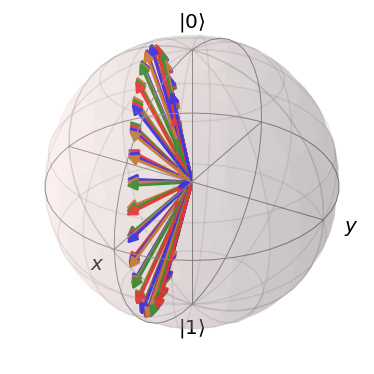

In [17]:
b = qt.Bloch()
state_matrix = np.empty(num_rows, dtype=qt.Qobj)
for i in range(0,num_rows):
    state_matrix[i] = qt.Qobj(evolution_matrix[i])

b.add_states(state_matrix)
b.render()

Hamiltonian:
 [[0.84145843+0.j         0.05385073+0.37888694j]
 [0.05385073-0.37888694j 0.42503254+0.j        ]]
Initial State:
 [0.4941447 +0.j 0.86937967+0.j]


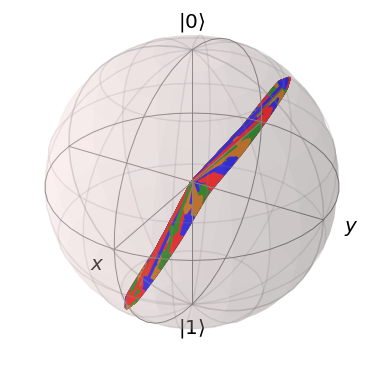

In [18]:
# choose random coefficients for hermitian hamiltonian
a=random.random()
b=random.random()
c=random.random()
d=random.random()
H = generate_hermitian(a,b,c,d)

# generate random 2 dimensional vector
initial_state = np.random.rand(2)

# change vector to have norm of 1
initial_state = initial_state/get_magnitude(initial_state)

# choose number of evolutions
num_rows = 1000
evolution_matrix = generate_evolution_matrix(initial_state,H,num_rows)

#extract real and imaginary parts out of evolution matrix
split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
for row in range(0,evolution_matrix.shape[0]):
    split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
    split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
    split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
    split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
# export evolution matrix as csv
'''
mat_df = pd.DataFrame(split_evolution_matrix)
mat_df.to_csv("evolution_data.csv")
'''

#visualize on bloch sphere
b = qt.Bloch()
state_matrix = np.empty(num_rows, dtype=qt.Qobj)
for i in range(0,num_rows):
    state_matrix[i] = qt.Qobj(evolution_matrix[i])
b.add_states(state_matrix)
b.render()

# print hamiltonian and initial vector
print("Hamiltonian:\n",H)
print("Initial State:\n",initial_state)

In [25]:
# unspecified dimension defaults to 2x2 hamiltonian
def generate_data_2d(filename,ham_filename,num_evolutions):
    # choose random coefficients for hermitian hamiltonian
    a=random.random()
    b=random.random()
    c=random.random()
    d=random.random()
    H = generate_hermitian(a,b,c,d)

    # generate random 2 dimensional vector
    vec = np.random.rand(2)

    # change vector to have norm of 1
    vec = vec/get_magnitude(vec)

    # choose number of evolutions
    num_rows = num_evolutions
    evolution_matrix = generate_evolution_matrix(vec,H,num_rows)

    #extract real and imaginary parts out of evolution matrix
    split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
    for row in range(0,evolution_matrix.shape[0]):
        split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
        split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
        split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
        split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
    # export data as csv
    mat_df = pd.DataFrame(split_evolution_matrix)
    mat_df.to_csv(filename)
    ham_df = pd.DataFrame(H)
    ham_df.to_csv(ham_filename)

In [20]:
# generalization for any dimensionality
def generate_data(filename,ham_filename,num_evolutions,dim):
    H = generate_random_hermitian(dim)
    vec = np.zeros(dim,np.cdouble)
    vec[0] = 1+0*1j
    evolution_matrix = generate_evolution_matrix(vec,H,num_evolutions)

    #extract real and imaginary parts out of evolution matrix
    split_evolution_matrix = np.zeros((evolution_matrix.shape[0],dim*2))
    for row in range(0,evolution_matrix.shape[0]):
        for i in range(0,dim):
            split_evolution_matrix[row,2*i] = np.real(evolution_matrix[row,i])
            split_evolution_matrix[row,2*i+1] = np.imag(evolution_matrix[row,i])
    
    # export data as csv
    mat_df = pd.DataFrame(split_evolution_matrix)
    mat_df.to_csv(filename)
    ham_df = pd.DataFrame(H)
    ham_df.to_csv(ham_filename)

In [27]:
for i in range(1,31):
    filename = "data/evolution_data/evolution_data" + str(i) + ".csv"
    ham_filename = "data/hamiltonians/hamiltonian" + str(i) + ".csv"
    generate_data_2d(filename,ham_filename,3000)

In [23]:
generate_data("evolution_data.csv","hamiltonian.csv",1000,50)